# Exploration of Prosper Loan Data
## by Truls Møller

## Introduction

The Prosper Loan dataset is a file on 113,937 personal loans that were originated 2006 - 2014, a time range which does include the 2008 Financial Crisis.

My analysis will focus on:
- **High-level overview** of the data.
- **Variables that seem (at least to me) relevant to decisions by the Lender _at the time a new loan gets originated_**, with the help of univariate plots to answer any questions that may arise.
- **Interaction between the variables** with the help of bivariate and multivariate plots to answer any questions that may arise on the interactions.

My analysis will _not_ focus on:
- Variables that become relevant in case of payment problems - defaulted and chargedoff loans - variables such as credit lines, recovery payments.

Here is a breakdown of the relevant variables in three categories.

1) BASIC LOAN DATA
- ListingCategory (numeric) : The category of listing. 20 categories from Debt Consolidation to Wedding Loans denoted with a number in the range 0-20 without any description.
- **ListingCategory** The category of listing. 20 categories from Debt Consolidation to Wedding Loans denoted with a number in the range 0-20 _with_ description.
- **LoanOriginationDate**: The date the loan was originated.
- **LoanOriginalAmount** : The origination amount of the loan.
- **BorrowerAPR**: The Borrower’s Annual Percentage Rate for the loan. (Yearly interest rate)
- **Term**: The duration of the loan in months (Three different durations found: 12, 36, 60 months, ie. 1, 3, 5 years)
- **Loan Status**: The current status of the loan: Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a time range on how long it is past due.

2) CREDIT GRADES / PROSPER RATINGS DATA
- CreditGrade : The Credit rating that was assigned at the time the listing went live. Used for listings pre-2009 only.
- ProsperRating (Alpha) : The Prosper Rating assigned at the time the listing was created, between AA - HR. Used for listings post-2008 only, hence complementary to CreditGrade.
- **ProsperRating** : Added column. It is the same as 'ProsperRating (Alpha)' only the missing data are populated from CreditGrade. This provides a nice continuity over time.

3) DATA THAT MIGHT HAVE AFFECTED CREDIT GRADES / PROSPER RATINGS
- **EmploymentStatus** Whether the borrower is employed, full-time, part-time, retired etc.
- **IncomeRange** : The income range of the borrower at the time the listing was created.
- **Borrower State** Two letter abbreviation of the state of the address of the borrower at the time of listing.
- **IsBorrowerHomeowner** True or False.
- **OnTimeProsperPayments** : Number of past on time payments (less that one month late) at the time of listing. Null if there are no prior loan history.
- **Recommendations** : Number of recommendations the borrower had at the time of listing.

All these variables will be used in our analysis, but only the ones in **bold** will be used explicitly.

## Preliminary Wrangling

In [155]:
# import all packages, set plots to be embedded inline, 
# set max display metrics 
# and the seaborn first color in palette as base_color

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

base_color = sb.color_palette()[0]

Loading the dataset:

In [2]:
df = pd.read_csv('prosperLoanData.csv')
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN

High level overview of data shape and composition:

In [3]:
print(df.shape)
print(df.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


We do some conversions of data type:

In [12]:
# We convert the 'Date' columns to datetime format

date_columns = ['ListingCreationDate', 'ClosedDate', 'DateCreditPulled', 'LoanOriginationDate']

for i in date_columns:
    df[i]= pd.to_datetime(df[i]).dt.normalize()

In [13]:
# We convert 'ListingNumber' and 'Term' to string type

df['ListingNumber'] = df['ListingNumber'].astype('str')
df['Term'] = df['Term'].astype('str')

Before we do conversions for categorical variables, we create a new column 'ProsperRating' where we first take all the data from column 'ProsperRating (Alpha)'s and then populate its missing values (pre-2009) with data from 'CreditGrade'. 

Note: This isn't perfect, but it follows the same rating scale (AA - A - B - C - D - E - HR), so it will give us some nice continuity across a gap in the data around the time of the 2008 financial crisis.

In [51]:
# We create the new column where we first take all the data from column 'ProsperRating (Alpha)'s 
# and then populate its missing values (pre-2009) with data from 'CreditGrade'.

df['ProsperRating'] = df['ProsperRating (Alpha)'].fillna(df['CreditGrade'])

# We check for missing data in our new column
df['ProsperRating'].isna().sum()

131

In [60]:
# We remove the missing data with pandas notnull function

df = df[pd.notnull(df['ProsperRating'])]

In [52]:
# The CreditGrade column also carried an extra value 'NC', 
# which we interpret as missing data as well ("Not Counted")

df['ProsperRating'].value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10443
AA     8881
NC      141
Name: ProsperRating, dtype: int64

In [61]:
# We remove that as well

df = df[df.ProsperRating != 'NC']

We verify that we only have the mentioned ratings

In [62]:
df['ProsperRating'].value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10443
AA     8881
Name: ProsperRating, dtype: int64

Great.

In [72]:
# We also remove the missing data in 'BorrowerAPR' with pandas notnull function

df = df[pd.notnull(df['BorrowerAPR'])]

One more step before we can move on to conversions for categorical variables:

In [76]:
# We want to add a column 'ListingCategory' and populate it 
# based on 'ListingCategory (numeric)'.

# First we create a dict for mapping between them
d = {0 : '0. Not Available',
     1 : '1. Debt Consolidation',
     2 : '2. Home Improvement', 
     3 : '3. Business', 
     4 : '4. Personal Loan', 
     5 : '5. Student Use',
     6 : '6. Auto',
     7 : '7. Other',
     8 : '8. Baby and Adoption', 
     9 : '9. Boat', 
     10 : '10. Cosmetic Procedure', 
     11 : '11. Engagement Ring',
     12 : '12. Green Loans',
     13 : '13. Household Expenses',
     14 : '14. Large Purchases',
     15 : '15. Medical/Dental',
     16 : '16. Motorcycle',
     17 : '17. RV',
     18 : '18. Taxes',
     19 : '19. Vacation',
     20 : '20. Wedding Loans'}

# we initialize the new column:

df['ListingCategory'] = '0. Not Available'

# and then we populate it.

for key in d:
    df.loc[df['ListingCategory (numeric)'] == key,'ListingCategory'] = d[key]

Great. Now we will perform conversions for categorical variables

In [64]:
# We convert Term, LoanStatus, ListingCategory and IncomeRange
# into ordered categorical types.

ordinal_var_dict = {'Term': ['12','36','60'],
                    'LoanStatus': ['Current', 'Completed','FinalPaymentInProgress', 
                                   'Past Due (1-15 days)', 'Past Due (16-30 days)', 
                                   'Past Due (31-60 days)', 'Past Due (61-90 days)', 
                                   'Past Due (90-120 days)', 'Past Due (>120 days)', 
                                   'Chargedoff', 'Defaulted'],
                    'ListingCategory': list(d.values()),
                    'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'],
                    'EmploymentStatus': ['Employed', 'Self-employed', 'Full-time', 'Part-time', 'Retired', 'Other', 'Not employed', 'Not available'], 
                    'ProsperRating': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

Let us inspect the data types

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113665 entries, 0 to 113936
Data columns (total 83 columns):
ListingKey                             113665 non-null object
ListingNumber                          113665 non-null object
ListingCreationDate                    113665 non-null datetime64[ns]
CreditGrade                            28812 non-null object
Term                                   113665 non-null category
LoanStatus                             113356 non-null category
ClosedDate                             54817 non-null datetime64[ns]
BorrowerAPR                            113641 non-null float64
BorrowerRate                           113665 non-null float64
LenderYield                            113665 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64


We see that the categorical data types are indeed there, and among them at the very bottom of the output we notice our new columns 'ListingCategory' and 'ProsperRating'.

### What is the structure of the dataset?

In [75]:
df.shape

(113641, 83)

There were initially 113,937 loan listings (rows) and 81 variables of data (columns) in the raw dataset.
We have dropped some rows due to missing data in key columns, and we have added two new columns.
Now we have 113,641 loan listings (rows) and 83 variables of data (columns).

As stated in the Introduction, we will focus on 13 variables:
- 1 is a datetime variable: 'LoanOriginationDate'.
- 6 are categorical variables: 'Term', 'LoanStatus', 'ListingCategory', 'IncomeRange', 'EmploymentStatus' and 'ProsperRating'.
- 4 are numeric variables: 'LoanOrginationAmount', 'BorrowerAPR', 'OnTimeProsperPayments', 'Recommendations'.
- 1 is a boolean variable: 'IsBorrowerHomeowner'.
- 1 is of string format: 'BorrowerState'


### What is/are the main feature(s) of interest in the dataset?

As stated in the Introduction, I will focus on the variables that seem relevant to decisions by the Lender at the time a new loan gets originated, as well as the clearly dependent variables 'ProsperRating' and 'BorrowerAPR'.

I am interested to find out:
- How does ProsperRating and the borrower’s APR (annual percentage rate) correlate?
- How does LoanOrginationAmount correlate with the borrower’s APR?
- Which seems to be the best predictor of a high ProsperRating - is it EmploymentStatus, IncomeRange, BorrowerState, IsBorrowerHomeowner, OnTimeProsperPayments or Recommendations?

### What features in the dataset do you think will help support the investigation into the feature(s) of interest?

It is only logical that 'ProsperRating' and 'BorrowerAPR' are dependent on each other, and both are calculated/decided by the Lender.

I would guess that 'LoanOrginationAmount' is a good predictor of the two. Small loans often have high interest rates.

'EmploymentStatus', 'IncomeRange', 'BorrowerState', 'IsBorrowerHomeowner', OnTimeProsperPayments and Recommendations might be helpful as well, but I do not have any clear opinion on which is better among these.

There is also the time aspect. We might discover some variations over time. If so, and if we wish to explore it, LoanOriginationDate will be absolutely cruicial.

## High Level Overview

We know the number of loans is a bit above 113k.

What is the total amount for all the loans? And what is the average amount?

In [78]:
print("Total loan amount: $ {:,.0f}".format(df['LoanOriginalAmount'].sum()))
print("Avg. loan amount: $ {0:,.0f}".format(df['LoanOriginalAmount'].mean()))

Total loan amount: $ 948,929,675
Avg. loan amount: $ 8,350


The total loan amount is nearly USD 1 billion, and the average loan amount a bit more than USD 8,000.

### Time Range

In [83]:
print(df.ListingCreationDate.dt.date.min())
print(df.ListingCreationDate.dt.date.max())

2006-01-06
2014-03-10


The data ranges from  Jan 6th 2006 to March 10th 2014.

### Loan amounts

Let us see what the most common loan amounts are.

In [20]:
df['LoanOriginalAmount'].value_counts()

4000     14333
15000    12407
10000    11106
5000      6990
2000      6067
         ...  
14383        1
6251         1
14447        1
6379         1
4098         1
Name: LoanOriginalAmount, Length: 2468, dtype: int64

The top 3 most common loan amounts each occur more than 10,000 times, and they are:
1. USD 4,000 (14k times)
2. USD 15,000 (12k times)
3. USD 10,000 (11k times)

We also note that there are "unique" amounts that occur only once.

### Pre- and Post-2008 Financial Crisis 

In case we want to investigate Pre- and Post-2008 Financial Crisis separately, we split it into two new DataFrames 'dfa' and 'dfb' for future use.

In [32]:
dfa = df[df['ListingCreationDate'].dt.year < 2009]
dfb = df[df['ListingCreationDate'].dt.year > 2008]

## Univariate Exploration

In this section we will explore our relevant variables individually. We will do this in the order of the categories defined in the Introduction: 
- BASIC LOAN DATA
- CREDIT GRADES / PROSPER RATINGS 
- DATA THAT MIGHT HAVE AFFECTED CREDIT GRADES / PROSPER RATINGS

### Basic Loan Data

#### ListingCategory

,ListingCategory
1. Debt Consolidation,0.512509
0. Not Available,0.147834
7. Other,0.092132
2. Home Improvement,0.065311
3. Business,0.063111
6. Auto,0.022571
4. Personal Loan,0.021075
13. Household Expenses,0.017564
15. Medical/Dental,0.013393
18. Taxes,0.007788


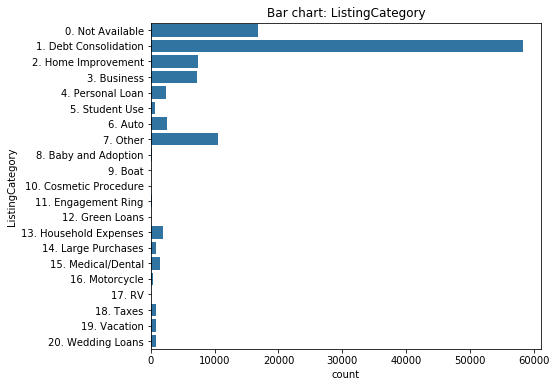

In [232]:
base_color = sb.color_palette()[0]
plt.subplots(figsize = [7,6])

# plotting the distribution of ListingCategory using seaborn's countplot
sb.countplot(data = df, y = 'ListingCategory', color = base_color, order = list(d.values()));

plt.title("Bar chart: ListingCategory");
pd.DataFrame(df['ListingCategory'].value_counts()/df['ListingCategory'].value_counts().sum())

Apparently, debt consolidation is a very large part of Prosper's loan business with 51 percent.
We note that 'Not Available' accounts for a quite large percentage with 14.8 percent.

In order to see the lower frequency types of loans more clearly, we try a log scale for the x-axis.

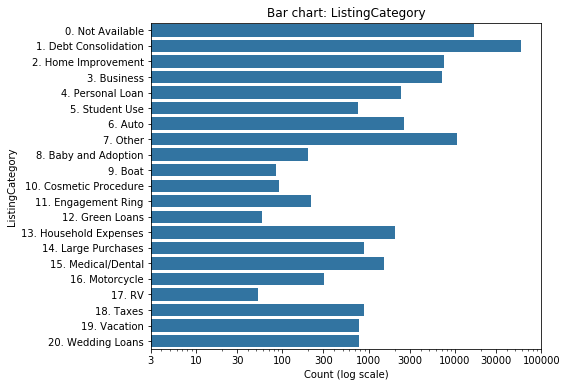

In [183]:
base_color = sb.color_palette()[0]
plt.subplots(figsize = [7,6])

# setting up for xticks suitable for log scale
tick_locs = [3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000] 

# plotting the distribution of ListingCategory using seaborn's countplot
sb.countplot(data = df, y = 'ListingCategory', color = base_color, order = list(d.values()));

plt.xscale('log') # choosing log scale for the x-axis
plt.xticks(tick_locs, tick_locs)
plt.xlabel("Count (log scale)")

plt.title("Bar chart: ListingCategory");

That made it much easier to see the lower frequency listing categories. All categories have at least 50 loans.

#### LoanOrginationDate

Let us have look at how the loans are distributed over time by plotting the 'LoanOriginationDate'.

We plot it in a histogram with 100 bins, which is approximately one bin per month:

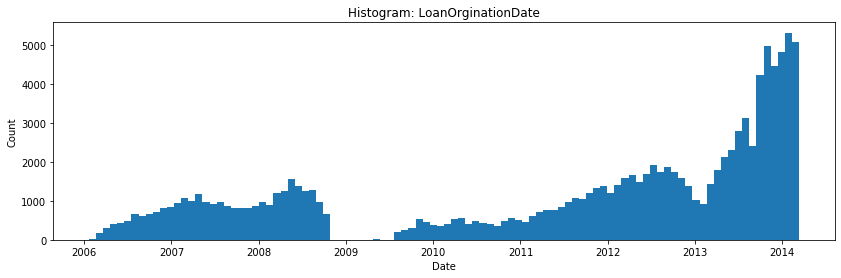

In [133]:
plt.figure(figsize = [14,4])

plt.hist(df["LoanOriginationDate"], bins = 100)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Histogram: LoanOrginationDate');

We can see there is a gap in the data between the fall of 2008 and the mid of 2009. It seems to coincide with the 2008 financial crisis. After the mid of 2009 the volume picks up for Prosper and, after a dip in late 2012, it takes off and the volume more than doubles the next 12 months!

Let us try plotting it with 3000 bins, which is approximately one bin per day:

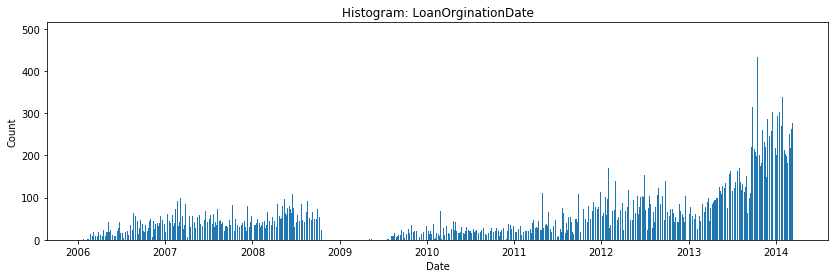

In [134]:
plt.figure(figsize = [14,4])

plt.hist(df["LoanOriginationDate"], bins = 3000)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Histogram: LoanOrginationDate');

How can the small gaps be explained?

In [130]:
df.LoanOriginationDate.dt.weekday.value_counts()

1    27201
2    25197
4    21742
3    21688
0    17813
Name: LoanOriginationDate, dtype: int64

We see that no loans are originated on Saturdays or Sundays, only on weekdays.

#### LoanOriginalAmount

How does the loan amount distribution look in a plot?

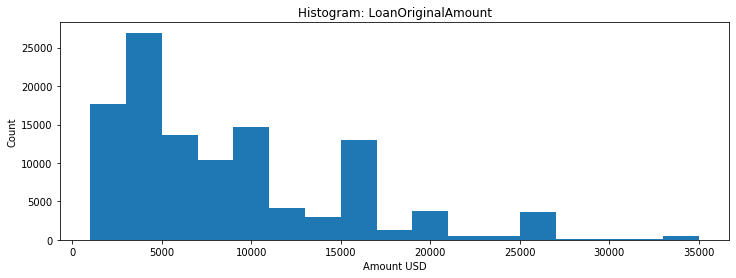

In [146]:
# We will use a histogram for this
plt.figure(figsize = [12,4])
bin_edges = np.arange(1000, df['LoanOriginalAmount'].max() + 2000, 2000)

plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin_edges)

plt.xlabel('Amount USD')
plt.ylabel('Count')
plt.title('Histogram: LoanOriginalAmount');

We can see that there seems to be a lot of smaller loans between \\$1,000 and \\$11,000, and there is a right-skew.

It would be nice to understand better what goes on around the peaks.

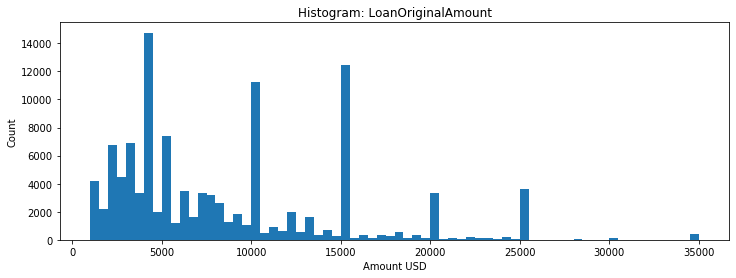

In [145]:
# We will use a histogram again and decrease the bin width compared to last time.
plt.figure(figsize = [12,4])
bin_edges = np.arange(1000, df['LoanOriginalAmount'].max() + 500, 500)

plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin_edges)

plt.xlabel('Amount USD')
plt.ylabel('Count')
plt.title('Histogram: LoanOriginalAmount');

We now recognize the top 3 most common loan amounts: \\$4,000, \\$10,000, \\$15,000, and there seems to be peaks at several round numbers, giving us a multimodal picture.

Maybe we will see some gaps if zoom in even more on those peaks.

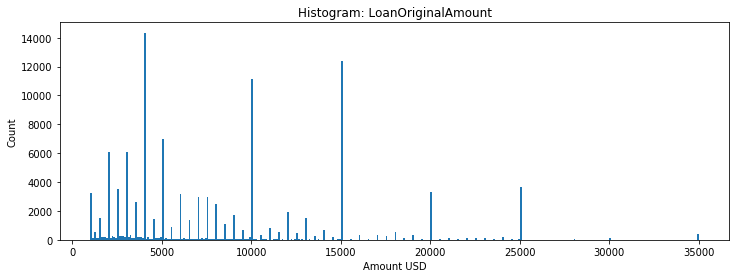

In [147]:
# We will use a histogram again and decrease the bin width even more.
plt.figure(figsize = [12,4])
bin_edges = np.arange(1000, df['LoanOriginalAmount'].max() + 100, 100)

plt.hist(data = df, x = 'LoanOriginalAmount', bins = bin_edges)

plt.xlabel('Amount USD')
plt.ylabel('Count')
plt.title('Histogram: LoanOriginalAmount');

Now we see more clearly that the loan amounts are almost discrete. However there are some odd amounts in between with significantly fewer occurrences than the peaks.

Ok. Now we have a better grasp. And it does make sense that most loan issued are in nice, round numbers.

#### BorrowerAPR

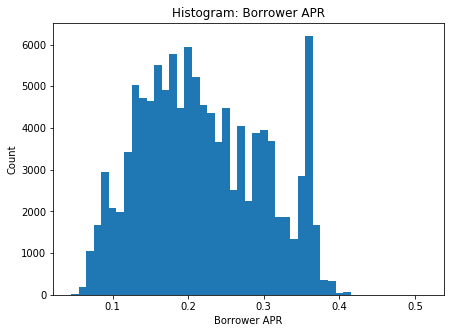

In [148]:
bins = np.arange(0.045, df['BorrowerAPR'].max() + 0.01, 0.01)
plt.subplots(figsize = [7,5])

plt.hist(df['BorrowerAPR'], bins = bins)

plt.xlabel("Borrower APR")
plt.ylabel("Count")
plt.title("Histogram: Borrower APR");

Borrower APR is fairly unimodal except for a peak around 0.36. Is there a particular type of loan with a fixed interest at 0.36?

In [224]:
df['BorrowerAPR'].value_counts()

0.35797    3672
0.35643    1644
0.37453    1260
0.30532     902
0.29510     747
           ... 
0.25094       1
0.29261       1
0.20944       1
0.06535       1
0.24672       1
Name: BorrowerAPR, Length: 6653, dtype: int64

In [229]:
peakAPR = df[(df['BorrowerAPR'] > 0.35796) & (df['BorrowerAPR'] < 0.35798)]
peakAPR

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,ListingCategory,ProsperRating
15,0F483544120452347F48121,577164,2012-04-10,NaN,36,Defaulted,2012-12-19,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,1.0,HR,5.0,13,FL,Other,Other,121.0,True,False,NaN,2012-04-10,700.0,719.0,1999-03-08 00:00:00,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,"$50,000-74,999",True,5500.000000,3EE2364952142596779635D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,8.0,23,63982,4000,2012-04-19,Q2 2012,924335448287456229847ED,173.71,521.13,209.75,311.38,-9.81,0.00,3790.25,3790.25,0.00,1.0000,0,0,0.0,10,13. Household Expenses,HR
31,0F683558129866945165D36,643927,2012-09-21,NaN,36,Current,NaT,0.35797,0.3177,0.3077,0.2896,0.1625,0.1271,1.0,HR,5.0,2,WI,Other,Other,44.0,False,False,NaN,2012-09-21,680.0,699.0,1979-05-01 00:00:00,0.0,0.0,21.0,0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,0.0,0.0,0.00,0.0,20.0,0.60,0.0,0.04,"$25,000-49,999",True,2250.000000,52C13661956879502774109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,18,75030,2000,2012-09-27,Q3 2012,C3EC355869195409459022F,86.85,1476.45,715.61,760.84,-23.95,0.00,0.00,0.00,0.00,1.0000,0,0,0.0,24,2. Home Improvement,HR
71,0DD23561917467486206661,658787,2012-10-23,NaN,36,Current,NaT,0.35797,0.3177,0.3077,0.2799,0.1625,0.1174,1.0,HR,4.0,13,CA,Other,Employed,141.0,True,False,NaN,2012-10-23,760.0,779.0,1992-02-01 00:00:00,20.0,14.0,75.0,13,219.0,2.0,11.0,0.0,0.0,4.0,0.0,0.0,7610.0,0.39,11195.0,72.0,1.00,0.0,0.53,"$25,000-49,999",True,2916.666667,668B36670958360892E4068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77739,2774,2012-11-15,Q4 2012,AF7235607399347974B8110,120.47,1807.05,840.76,966.29,-30.43,0.00,0.00,0.00,0.00,0.9247,0,0,0.0,49,13. Household Expenses,HR
94,0FEE354060248231998406E,563980,2012-02-29,NaN,36,Current,NaT,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,1.0,HR,3.0,7,MO,Military Officer,Employed,33.0,True,False,NaN,2012-02-29,700.0,719.0,2005-09-20 00:00:00,15.0,13.0,23.0,7,478.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,17878.0,0.92,833.0,17.0,1.00,3.0,0.43,"$50,000-74,999",True,5196.250000,25013645183307735D78AF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,24,61584,4000,2012-03-05,Q1 2012,2B163539729377704DEE232,173.71,3995.33,2101.75,1893.58,-59.58,0.00,0.00,0.00,0.00,1.0000,0,0,0.0,6,7. Other,HR
107,10BE354254173728633D033,573446,2012-03-29,NaN,36,Defaulted,2012-12-23,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,1.0,HR,2.0,1,OH,Administrative Assistant,Employed,84.0,False,False,NaN,2012-0

In [230]:
peakAPR.ProsperRating.value_counts()

HR    3672
E        0
D        0
C        0
B        0
A        0
AA       0
Name: ProsperRating, dtype: int64

They all have ProsperRating 'HR'. In later bi-variate plot we should surely pair up BorrowerAPR with ProsperRating.

#### Term

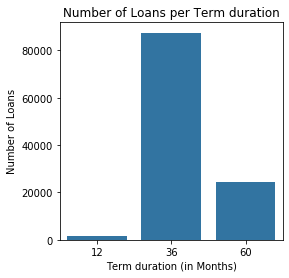

In [162]:
plt.subplots(figsize = [4,4])

sb.countplot(data = df, x = 'Term', color = base_color)

plt.title("Number of Loans per Term duration")
plt.ylabel("Number of Loans")
plt.xlabel("Term duration (in Months)");

Let us plot it in relative terms as well:

In [180]:
# create set of evenly spaced tick_props and some tick_names

term_counts = df['Term'].value_counts()
n = df.shape[0]
max_term_count = term_counts.max()
max_prop = max_term_count/n
tick_props = np.arange(0, max_prop + 0.1, 0.1)

tick_names = ['{:0.2f}'.format(v) for v in tick_props]

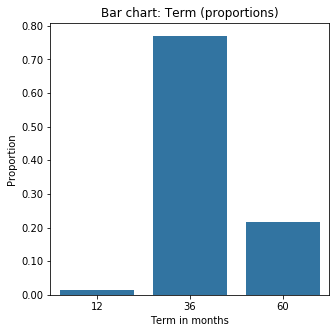

In [184]:
plt.subplots(figsize = [5,5])

sb.countplot(data = df, x = 'Term', color = base_color)

plt.yticks(tick_props*n, tick_names)
plt.xlabel("Term in months")
plt.ylabel("Proportion")
plt.title("Bar chart: Term (proportions)");

Ok. Now we can see the proportional values from the barchart.

#### LoanStatus

,LoanStatus
Current,0.499206
Completed,0.334292
Chargedoff,0.105451
Defaulted,0.043686
Past Due (1-15 days),0.007112
Past Due (31-60 days),0.003203
Past Due (61-90 days),0.002762
Past Due (16-30 days),0.002338
FinalPaymentInProgress,0.001809
Past Due (>120 days),0.000141


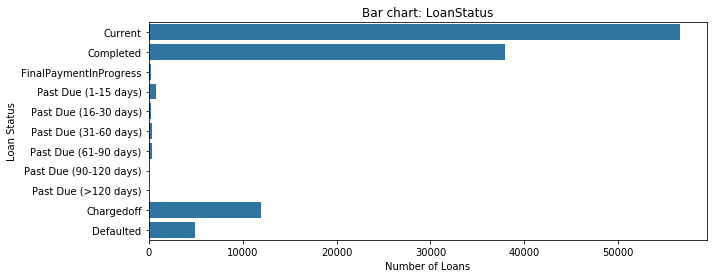

In [231]:
plt.subplots(figsize = [10,4])

sb.countplot(data = df, y = 'LoanStatus', color = base_color)

plt.title("Bar chart: LoanStatus")
plt.xlabel("Number of Loans")
plt.ylabel("Loan Status");
pd.DataFrame(df['LoanStatus'].value_counts()/df['LoanStatus'].value_counts().sum())

50 percent is Current, 33 percent is Completed, 11 percent is Chargedoff and 4 percent is Defaulted. These four values account for 98 percent of the loans. 

The rest is hard to read from the chart, so let us plot it again with a log scale on the x-axis:

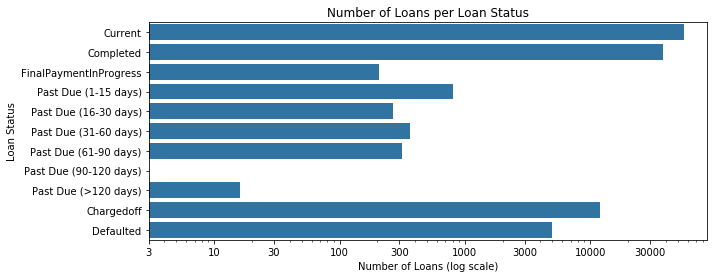

In [194]:
tick_locs = [3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]
plt.subplots(figsize = [10,4])

sb.countplot(data = df, y = 'LoanStatus', color = base_color);

plt.xscale('log')
plt.xticks(tick_locs, tick_locs)
plt.xlabel("Number of Loans (log scale)")
plt.ylabel("Loan Status")
plt.title("Number of Loans per Loan Status");

Now it's easier to read, and if we compare the PastDue ranges, they are pretty evenly distributed up to 90 days with 200-1000 loans each. After the 90 day point there are way fewer when the threat of being chargedoff comes closer. There might be some warning letters distributed in advance, but that we cannot say for sure. Regardsless, we do not plan to dive into the payment problems, as also stated in the Introduction. 

### Credit Grades / Prosper Ratings

Due to the fact that we merged CreditGrade into the ProsperRating, only the latter is a variable of interest in this category.

#### ProsperRating

ProsperRating is a categorical variable. A bar chart should be a suitable plot.

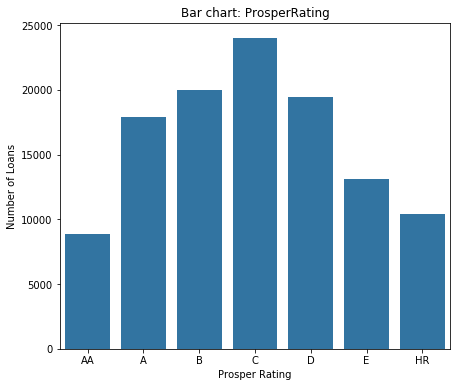

In [185]:
plt.subplots(figsize = [7,6])

sb.countplot(data = df, x = 'ProsperRating', color = base_color)

plt.title("Bar chart: ProsperRating")
plt.ylabel("Number of Loans")
plt.xlabel("Prosper Rating");

The distribution looks unimodal and quite symmertric, with the middle rating C having the highest count of loans.

### Data That Might Have Affected Credit Grades / Prosper Ratings

#### Employment Status

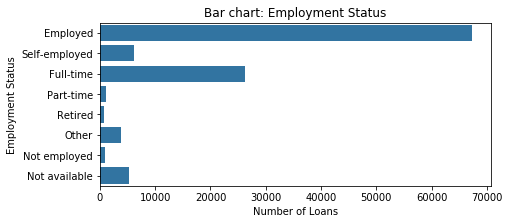

In [198]:
plt.subplots(figsize = [7,3])

sb.countplot(data = df, y = 'EmploymentStatus', color = base_color);

plt.xlabel("Number of Loans")
plt.ylabel("Employment Status")
plt.title("Bar chart: Employment Status");

The categories aren't great. 'Employed' is most likely a mix of Self-Employed, Full-time and Part-time. And with 'Employed' as the most frequent value, I believe we will not use it in future bivariate and multivariate exploration.

#### IncomeRange

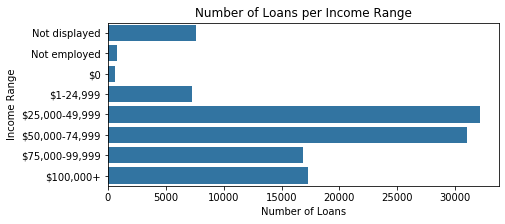

In [195]:
plt.subplots(figsize = [7,3])

sb.countplot(data = df, y = 'IncomeRange', color = base_color);

plt.xlabel("Number of Loans")
plt.ylabel("Income Range")
plt.title("Number of Loans per Income Range");

Income ranges are well-defined and we have a good amount of data points in each range, unimodal with a peak around 50k dollars. This variable can definately be used in future bivariate/multivariate exploration.

#### IsBorrowerHomeowner

,IsBorrowerHomeowner
True,0.505205
False,0.494795


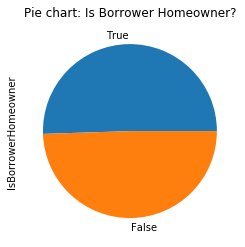

In [203]:
ax = df['IsBorrowerHomeowner'].value_counts().plot(kind='pie')
ax.set_title('Pie chart: Is Borrower Homeowner?')
pd.DataFrame(df['IsBorrowerHomeowner'].value_counts()/df['IsBorrowerHomeowner'].value_counts().sum())

Only a slight majority are homeowners (50.5 percent). This could be used for later bi-/multi-variate exploration if it turns out to be a good indicator.

#### OnTimeProsperPayments

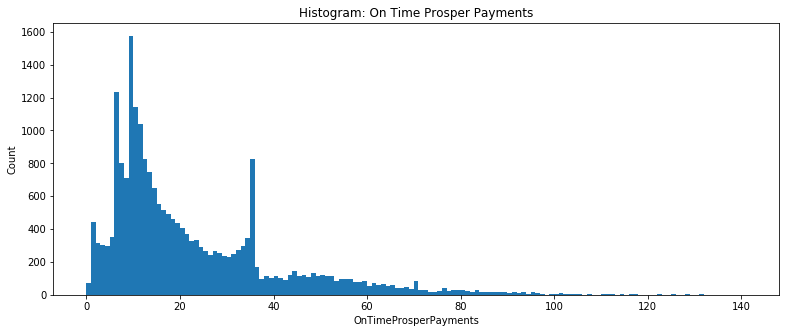

In [212]:
bins = np.arange(0, df['OnTimeProsperPayments'].max() + 1, 1)
plt.subplots(figsize = [13,5])

plt.hist(df['OnTimeProsperPayments'], bins = bins)

plt.xlabel("OnTimeProsperPayments")
plt.ylabel("Count")
plt.title("Histogram: On Time Prosper Payments");

For 'OnTimeProsperPayments' there are peaks arond 10-12 and 36. There are a lot of Current loans (ongoing) with longer term that clouds the picture that 12 is a "good" number. It would be more likely that 36 is a "good" number, because 36 months is the most common duration of a loan. A high number like 80 could be good, but it could also be bad, because there could be several small loans in the history of a borrower with high average APR, for instance, and I would think there is less reason to think that 80 means 80 out of 80 where paid on time compared to 36 meaning 36 out of 36. It would be better to have this as a percentage. Then 100 percent ontime payment would certainly be a positive. I do not think I will use this in future multivariate plots. 

#### Recommendations

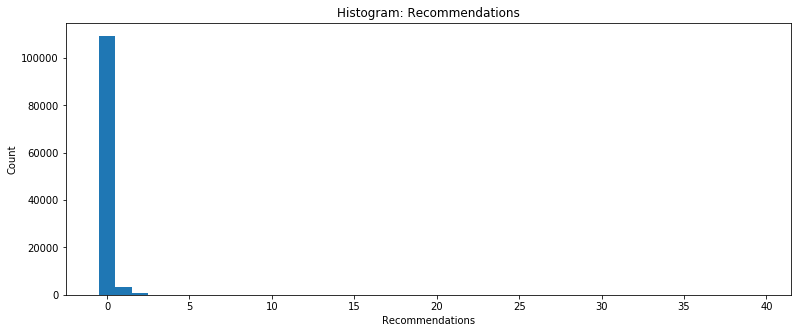

In [217]:
bins = np.arange(-0.5, df['Recommendations'].max() + 1, 1)
plt.subplots(figsize = [13,5])

plt.hist(df['Recommendations'], bins = bins)

plt.xlabel("Recommendations")
plt.ylabel("Count")
plt.title("Histogram: Recommendations");

Clearly recommendations are rare. Most borrowers have zero. Let us try this with a log scale on the y-axis:

,Recommendations
0,0.962610
1,0.030860
2,0.004989
3,0.000950
4,0.000229
5,0.000123
9,0.000053
7,0.000044
6,0.000035
8,0.000026


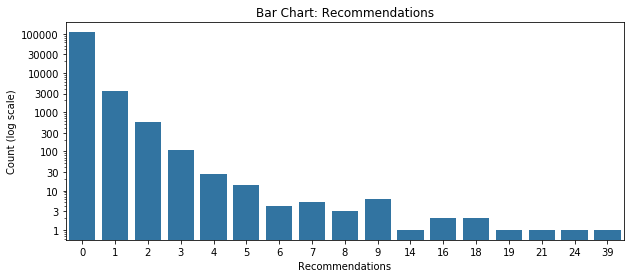

In [223]:
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.subplots(figsize = [10,4])

sb.countplot(data = df, x = 'Recommendations', color = base_color);

plt.yscale('log')
plt.yticks(tick_locs, tick_locs)
plt.ylabel("Count (log scale)")
plt.xlabel("Recommendations")
plt.title("Bar Chart: Recommendations");
pd.DataFrame(df['Recommendations'].value_counts()/df['Recommendations'].value_counts().sum())

3.1 percent have 1 recommendation.
0.5 percent have 2 recommendations.
0.1 percent have 3 recommendations.
etc.

So few have them, but does that mean they are valuable? We will find out in later chapters.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
ListingCategory (log transform) - debt consolidation is a very large part of Prosper's loan business with 51 percent.
We note that 'Not Available' accounts for a quite large percentage with 14.8 percent.

LoanOriginationDate - revealed a gap in new business around the financial crisis, or maybe they were out of business. Then the volumes of loans originated skyrocketed the last one year 2013-14 and more than doubled.

LoanOrginalAmount - common loan sizes at round numbers like 4k, 10k and 15k dollars leads to many peaks.

Term - plotted both an absolute and a relative bar chart. 36 months the most common duration.

LoanStatus (log transform) - Current/Completed/ChargedOff/Defaulted the most common categories

ProsperRating - nice unimodal and symmetric distribution

IncomeRange - good amount of data points in each range, unimodal with a peak around 50k dollars

IsBorrowerHomeowner - Almost 50/50

OnTimeProsperPayments - maybe not that useful, since it say anything about the proportion of on time payments.

Recommendations (log transform) - 96.2 percent of loans, the borrower does not have recommendations


### Of the features you investigated, were there any unusual distributions? 
Yes, the ones where I did a log transform, there where a lot of values with very low frequency. Log transform was necessary to distinguish them.

### Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Yes, for ProsperRating I added a new column where I first took all the data from column 'ProsperRating (Alpha)'s and then populated its missing values (pre-2009) with data from 'CreditGrade'. This was possible because it follows the same rating scale (AA - A - B - C - D - E - HR).

And for 'ListingCategory (numeric)' I added text and put it in a new column 'ListingCategory' for improved readability and turned it into an ordered categorical type.

## Bivariate Exploration

- 1 is a datetime variable: 'LoanOriginationDate'.
- 6 are categorical variables: 'Term', 'LoanStatus', 'ListingCategory', 'IncomeRange', 'EmploymentStatus' and 'ProsperRating'.
- 4 are numeric variables: 'LoanOrginationAmount', 'BorrowerAPR', 'OnTimeProsperPayments', 'Recommendations'.
- 1 is a boolean variable: 'IsBorrowerHomeowner'.
- 1 is of string format: 'BorrowerState'

In [245]:
numeric_vars = ['BorrowerAPR', 'LoanOriginalAmount', 'CreditScoreRangeLower']
categoric_vars = ['ProsperRating', 'Term', 'LoanStatus', 'ListingCategory', 'IncomeRange']

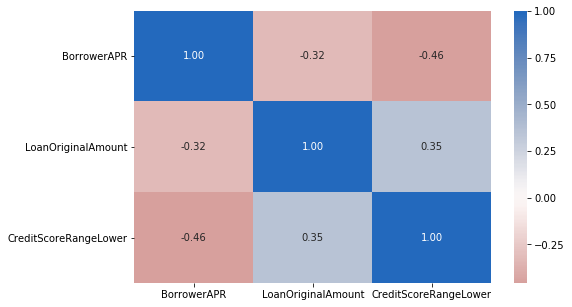

In [247]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0)
plt.show()

C:\Anaconda3\envs\dand\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Anaconda3\envs\dand\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda3\envs\dand\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


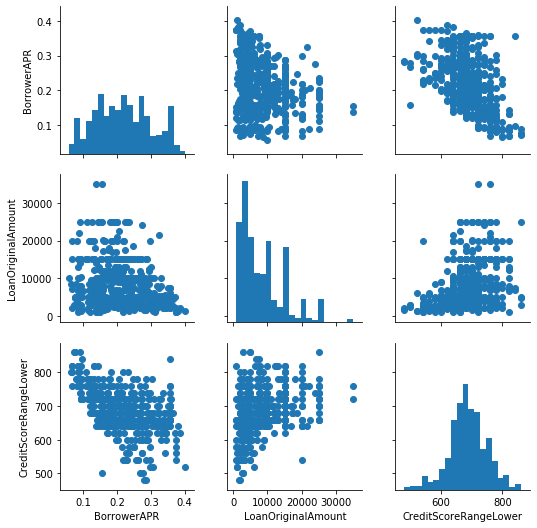

In [248]:
# plot matrix: sample 500 loans so that plots are clearer and
# they render faster
samples = np.random.choice(df.shape[0], 500, replace = False)
df_samp = df.loc[samples,:]

g = sb.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

In [260]:
df.IncomeRange.value_counts()

$25,000-49,999    32152
$50,000-74,999    31005
$100,000+         17321
$75,000-99,999    16899
Not displayed      7576
$1-24,999          7261
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64

C:\Anaconda3\envs\dand\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


<Figure size 720x720 with 0 Axes>

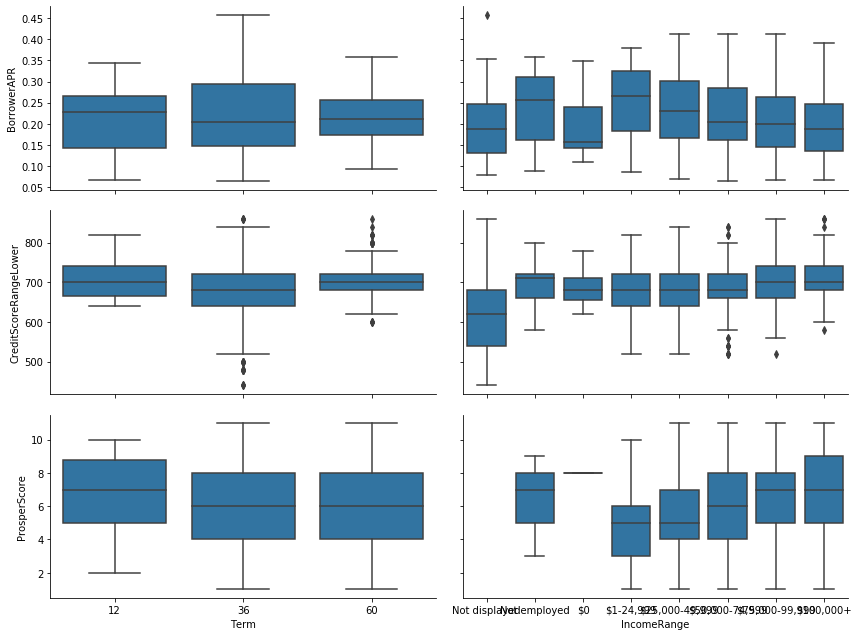

In [259]:
# plot matrix of numeric features against categorical features.
# can use a larger sample since there are fewer plots and they're simpler

samples = np.random.choice(df.shape[0], 2000, replace = False)
df_samp = df.loc[samples,:]

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_samp, y_vars = ['BorrowerAPR', 'CreditScoreRangeLower', 'ProsperScore'], x_vars = ['Term', 'IncomeRange'],
                height = 3, aspect = 2)
g.map(boxgrid)
plt.show();

In [ ]:
['ProsperRating', 'Term', 'IncomeRange']

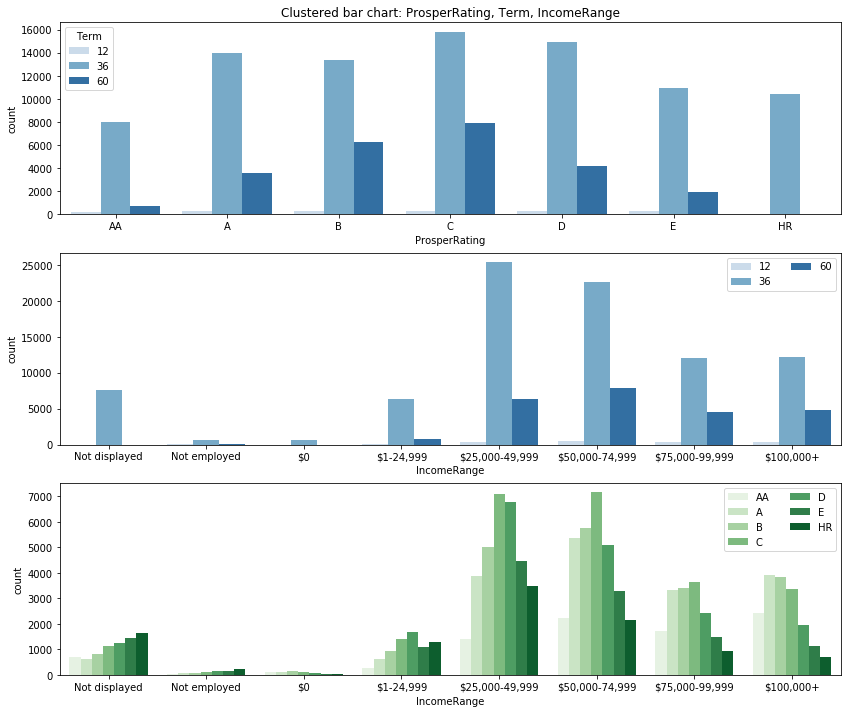

In [255]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize = [14, 12])

# subplot 1: ProsperRating vs Term
plt.subplot(3, 1, 1)
sb.countplot(data = df, x = 'ProsperRating', hue = 'Term', palette = 'Blues')
plt.title('Clustered bar chart: ProsperRating, Term, IncomeRange')

# subplot 2: IncomeRange vs. Term
ax = plt.subplot(3, 1, 2)
sb.countplot(data = df, x = 'IncomeRange', hue = 'Term', palette = 'Blues')
ax.legend(ncol = 2) # re-arrange legend to reduce overlapping

# subplot 3: IncomeRange vs. color, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = df, x = 'IncomeRange', hue = 'ProsperRating', palette = 'Greens')
ax.legend(loc = 1, ncol = 2) # re-arrange legend to remove overlapping

plt.show()

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!